<center>
    <h3>Stock Sales Data Insights</h3>
    <hr>
    <h1>Elementary Data Analysis & Modelling</h1>
    <h3>June 05, 2020</h3>
</center>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder

In [ ]:
project_dir = '/content/drive/My Drive/TEAM2/Data/'
df = pd.read_csv(project_dir+'client_prices_stats.csv',parse_dates = ['date'])
#shared drive dir: '/content/drive/Shared drives/TestProject/
df.head()

,date,ticker,buy_sell,quantity,clientNum,open,high,low,close,adj_close,volume,tnx,log_return,log_return_5d,log_return_22d,log_return_3m,log_return_52w,std_5d,std_22d,std_3m,std_52w,high_52w,low_52w,VaR_10d,sp_return,beta_1y,sharpe,sharpe_mov_avg_5d,clientName,company_name,gics_sector,gics_sub_industry,headquarters_location,date_first_added,cik,founded,headquarters_location_city,headquarters_location_state,headquarters_location_country
0,2019-04-02,WHR,buy,100,1,134.410004,135.149994,133.399994,134.589996,133.354095,563700.0,2.481,0.000892,0.027418,-0.048723,0.238698,-0.077113,0.004315,0.018397,0.020795,0.021877,167.539993,99.400002,-0.181135,0.000017,0.924560,-0.920327,-1.116654,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States
1,2019-04-10,WHR,sell,200,1,135.429993,137.300003,134.740005,137.029999,135.771683,568200.0,2.477,0.016556,0.031581,0.003143,0.128446,-0.054883,0.016297,0.019347,0.019944,0.021885,167.539993,99.400002,-0.181135,0.003472,0.931138,-0.713979,-0.786402,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States
2,2019-04-12,WHR,buy,200,1,139.500000,140.630005,138.460007,139.880005,138.595520,865300.0,2.560,0.001145,0.027322,-0.008684,0.135947,-0.029011,0.017197,0.018551,0.020048,0.021917,167.539993,99.400002,-0.181135,0.006588,0.931808,-0.485541,-0.591307,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States
3,2019-04-22,WHR,sell,100,1,139.380005,141.250000,138.910004,139.360001,138.080292,1789500.0,2.590,0.002155,-0.003724,0.065687,0.100479,-0.052534,0.015495,0.015675,0.020255,0.021870,167.539993,99.400002,-0.181135,0.001012,0.926019,-0.694880,-0.821194,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States
4,2019-06-27,WHR,buy,300,1,140.559998,142.839996,140.559998,142.309998,142.309998,559100.0,2.005,0.018224,0.007547,0.149897,0.084052,0.021902,0.015941,0.022298,0.018999,0.022222,156.509995,99.400002,-0.181135,0.003816,1.063270,0.014618,-0.112831,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States


In [ ]:
project_dir = '/content/drive/My Drive/TEAM2/Data/'
df = pd.read_csv(project_dir+'client_prices_stats_with_commissions.csv',parse_dates = True)
#shared drive dir: '/content/drive/Shared drives/TestProject/
df.head()

,date,ticker,buy_sell,quantity,clientNum,open,high,low,close,adj_close,volume,tnx,log_return,log_return_5d,log_return_22d,log_return_3m,log_return_52w,std_5d,std_22d,std_3m,std_52w,high_52w,low_52w,VaR_10d,sp_return,beta_1y,sharpe,sharpe_mov_avg_5d,clientName,company_name,gics_sector,gics_sub_industry,headquarters_location,date_first_added,cik,founded,headquarters_location_city,headquarters_location_state,headquarters_location_country,Fee/Share,Total Commission
0,2019-04-02,WHR,buy,100,1,134.410004,135.149994,133.399994,134.589996,133.354095,563700.0,2.481,0.000892,0.027418,-0.048723,0.238698,-0.077113,0.004315,0.018397,0.020795,0.021877,167.539993,99.400002,-0.181135,0.000017,0.924560,-0.920327,-1.116654,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States,0.125,12.5
1,2019-04-10,WHR,sell,200,1,135.429993,137.300003,134.740005,137.029999,135.771683,568200.0,2.477,0.016556,0.031581,0.003143,0.128446,-0.054883,0.016297,0.019347,0.019944,0.021885,167.539993,99.400002,-0.181135,0.003472,0.931138,-0.713979,-0.786402,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States,0.125,25.0
2,2019-04-12,WHR,buy,200,1,139.500000,140.630005,138.460007,139.880005,138.595520,865300.0,2.560,0.001145,0.027322,-0.008684,0.135947,-0.029011,0.017197,0.018551,0.020048,0.021917,167.539993,99.400002,-0.181135,0.006588,0.931808,-0.485541,-0.591307,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States,0.125,25.0
3,2019-04-22,WHR,sell,100,1,139.380005,141.250000,138.910004,139.360001,138.080292,1789500.0,2.590,0.002155,-0.003724,0.065687,0.100479,-0.052534,0.015495,0.015675,0.020255,0.021870,167.539993,99.400002,-0.181135,0.001012,0.926019,-0.694880,-0.821194,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States,0.125,12.5
4,2019-06-27,WHR,buy,300,1,140.559998,142.839996,140.559998,142.309998,142.309998,559100.0,2.005,0.018224,0.007547,0.149897,0.084052,0.021902,0.015941,0.022298,0.018999,0.022222,156.509995,99.400002,-0.181135,0.003816,1.063270,0.014618,-0.112831,CapitalAlley Funds,Whirlpool Corp.,Consumer Discretionary,Household Appliances,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,Michigan,United States,0.125,37.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5849 entries, 0 to 5848
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           5849 non-null   object 
 1   ticker                         5849 non-null   object 
 2   buy_sell                       5849 non-null   object 
 3   quantity                       5849 non-null   int64  
 4   clientNum                      5849 non-null   int64  
 5   open                           5849 non-null   float64
 6   high                           5849 non-null   float64
 7   low                            5849 non-null   float64
 8   close                          5849 non-null   float64
 9   adj_close                      5849 non-null   float64
 10  volume                         5849 non-null   float64
 11  tnx                            5849 non-null   float64
 12  log_return                     5849 non-null   f

# Feature Extract
**df_stock:** feature extract for stock similarity analysis

**df_client:** feature extract for client similarity analysis

In [ ]:
df_stock = df.copy()

In [ ]:
#df_stock['month'] = pd.DatetimeIndex(df_stock['date']).month

In [ ]:
# one hot encoding categorical data
X = df_stock[['buy_sell','gics_sector','gics_sub_industry','headquarters_location_state']]
enc = OneHotEncoder(handle_unknown='ignore')
df_stock_cat = pd.DataFrame(enc.fit_transform(X).toarray(),columns=enc.get_feature_names())
df_stock_cat.head()

,x0_buy,x0_sell,x1_Communication Services,x1_Consumer Discretionary,x1_Consumer Staples,x1_Energy,x1_Financials,x1_Information Technology,x1_Materials,x2_Apparel Retail,"x2_Apparel, Accessories & Luxury Goods",x2_Application Software,x2_Automobile Manufacturers,x2_Brewers,x2_Casinos & Gaming,x2_Communications Equipment,x2_Computer & Electronics Retail,x2_Data Processing & Outsources Services,x2_Department Stores,x2_Diversified Banks,x2_Drug Retail,x2_Electronic Components,x2_General Merchandise Stores,x2_Gold,x2_Home Improvement Retail,"x2_Hotels, Resorts & Cruise Lines",x2_Household Appliances,x2_Hypermarkets & Super Centers,x2_IT Services,x2_Integrated Telecommunication Services,x2_Interactive Home Entertainment,x2_Interactive Media & Services,x2_Internet & Direct Marketing Retail,x2_Internet Software & Services,x2_Movies & Entertainment,x2_Oil & Gas Exploration & Production,x2_Packaged Foods & Meats,x2_Personal Products,x2_Restaurants,x2_Semiconductor Equipment,x2_Semiconductors,x2_Soft Drinks,x2_Systems Software,"x2_Technology Hardware, Storage & Peripherals",x3_California,x3_Colorado,x3_Florida,x3_Georgia,x3_Illinois,x3_Massachusetts,x3_Michigan,x3_Minnesota,x3_Nevada,x3_New York,x3_North Carolina,x3_Ohio,x3_Oregon,x3_Tennessee,x3_Texas,x3_Washington
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_stock_encoded = df_stock.drop(['clientNum','buy_sell','gics_sector','gics_sub_industry','headquarters_location_state'],axis=1)
df_stock_encoded = pd.concat([df_stock_encoded,df_stock_cat],axis=1)
df_stock_encoded.head()

,date,ticker,quantity,open,high,low,close,adj_close,volume,tnx,log_return,log_return_5d,log_return_22d,log_return_3m,log_return_52w,std_5d,std_22d,std_3m,std_52w,high_52w,low_52w,VaR_10d,sp_return,beta_1y,sharpe,sharpe_mov_avg_5d,clientName,company_name,headquarters_location,date_first_added,cik,founded,headquarters_location_city,headquarters_location_country,Fee/Share,Total Commission,x0_buy,x0_sell,x1_Communication Services,x1_Consumer Discretionary,...,x2_Drug Retail,x2_Electronic Components,x2_General Merchandise Stores,x2_Gold,x2_Home Improvement Retail,"x2_Hotels, Resorts & Cruise Lines",x2_Household Appliances,x2_Hypermarkets & Super Centers,x2_IT Services,x2_Integrated Telecommunication Services,x2_Interactive Home Entertainment,x2_Interactive Media & Services,x2_Internet & Direct Marketing Retail,x2_Internet Software & Services,x2_Movies & Entertainment,x2_Oil & Gas Exploration & Production,x2_Packaged Foods & Meats,x2_Personal Products,x2_Restaurants,x2_Semiconductor Equipment,x2_Semiconductors,x2_Soft Drinks,x2_Systems Software,"x2_Technology Hardware, Storage & Peripherals",x3_California,x3_Colorado,x3_Florida,x3_Georgia,x3_Illinois,x3_Massachusetts,x3_Michigan,x3_Minnesota,x3_Nevada,x3_New York,x3_North Carolina,x3_Ohio,x3_Oregon,x3_Tennessee,x3_Texas,x3_Washington
0,2019-04-02,WHR,100,134.410004,135.149994,133.399994,134.589996,133.354095,563700.0,2.481,0.000892,0.027418,-0.048723,0.238698,-0.077113,0.004315,0.018397,0.020795,0.021877,167.539993,99.400002,-0.181135,0.000017,0.924560,-0.920327,-1.116654,CapitalAlley Funds,Whirlpool Corp.,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,United States,0.125,12.5,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-04-10,WHR,200,135.429993,137.300003,134.740005,137.029999,135.771683,568200.0,2.477,0.016556,0.031581,0.003143,0.128446,-0.054883,0.016297,0.019347,0.019944,0.021885,167.539993,99.400002,-0.181135,0.003472,0.931138,-0.713979,-0.786402,CapitalAlley Funds,Whirlpool Corp.,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,United States,0.125,25.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-04-12,WHR,200,139.500000,140.630005,138.460007,139.880005,138.595520,865300.0,2.560,0.001145,0.027322,-0.008684,0.135947,-0.029011,0.017197,0.018551,0.020048,0.021917,167.539993,99.400002,-0.181135,0.006588,0.931808,-0.485541,-0.591307,CapitalAlley Funds,Whirlpool Corp.,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,United States,0.125,25.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-04-22,WHR,100,139.380005,141.250000,138.910004,139.360001,138.080292,1789500.0,2.590,0.002155,-0.003724,0.065687,0.100479,-0.052534,0.015495,0.015675,0.020255,0.021870,167.539993,99.400002,-0.181135,0.001012,0.926019,-0.694880,-0.821194,CapitalAlley Funds,Whirlpool Corp.,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,United States,0.125,12.5,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-06-27,WHR,300,140.559998,142.839996,140.559998,142.309998,142.309998,559100.0,2.005,0.018224,0.007547,0.149897,0.084052,0.021902,0.015941,0.022298,0.018999,0.022222,156.509995,99.400002,-0.181135,0.003816,1.063270,0.014618,-0.112831,CapitalAlley Funds,Whirlpool Corp.,"Benton Harbor, Michigan",NaN,106640,1911,Benton Harbor,United States,0.125,37.5,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tickers = df_stock_encoded.ticker.unique()
tickers.sort()
print(tickers)
df_stock_encoded["ticker"] = df_stock_encoded.ticker.apply(lambda x: np.where(tickers==x)[0][0])


['AAPL' 'ADBE' 'ADI' 'AMD' 'AVGO' 'BAC' 'BBY' 'C' 'CCL' 'CMG' 'COST' 'CRM'
 'CSCO' 'CTXS' 'DG' 'DIS' 'EA' 'EXPE' 'FLT' 'GIS' 'GLW' 'GM' 'HD' 'INTC'
 'JNPR' 'JPM' 'JWN' 'LRCX' 'MA' 'MSFT' 'MSI' 'NBL' 'NEM' 'NKE' 'NVDA'
 'PEP' 'PG' 'QCOM' 'QRVO' 'SWKS' 'T' 'TAP' 'TJX' 'TRIP' 'TXN' 'V' 'WBA'
 'WDC' 'WHR' 'WYNN']


In [ ]:
df_stock_encoded_sum_buy = df_stock_encoded[df_stock_encoded['x0_buy']==1][['ticker','quantity']].groupby(['ticker']).sum()
df_stock_encoded_sum_sell = df_stock_encoded[df_stock_encoded['x0_buy']==0][['ticker','quantity']].groupby(['ticker']).sum()
df_stock_encoded_sum = pd.concat([df_stock_encoded_sum_buy,df_stock_encoded_sum_sell],axis=1)
df_stock_encoded_sum.columns = ['quantity_sum_buy','quantity_sum_sell']
df_stock_encoded_sum['imbalance'] = (df_stock_encoded_sum['quantity_sum_buy'] - df_stock_encoded_sum['quantity_sum_sell'])/(df_stock_encoded_sum['quantity_sum_buy']+df_stock_encoded_sum['quantity_sum_sell'])
df_stock_encoded_sum['quantity_sum'] = (df_stock_encoded_sum['quantity_sum_buy'] + df_stock_encoded_sum['quantity_sum_sell'])
df_stock_encoded_sum.head()

,quantity_sum_buy,quantity_sum_sell,imbalance,quantity_sum
ticker,,,,
0,54000,49700,0.041466,103700
1,89500,74600,0.090798,164100
2,71100,57700,0.104037,128800
3,55800,54100,0.015469,109900
4,68600,60400,0.063566,129000


In [ ]:
df_stock_encoded['range'] = (df_stock_encoded.high - df_stock_encoded.low)/df_stock_encoded.adj_close
df_stock_encoded['range_52w'] = (df_stock_encoded.high_52w - df_stock_encoded.low_52w)/df_stock_encoded.adj_close
df_stock_encoded = df_stock_encoded.drop(['high', 'low', 'high_52w', 'low_52w'], axis=1)

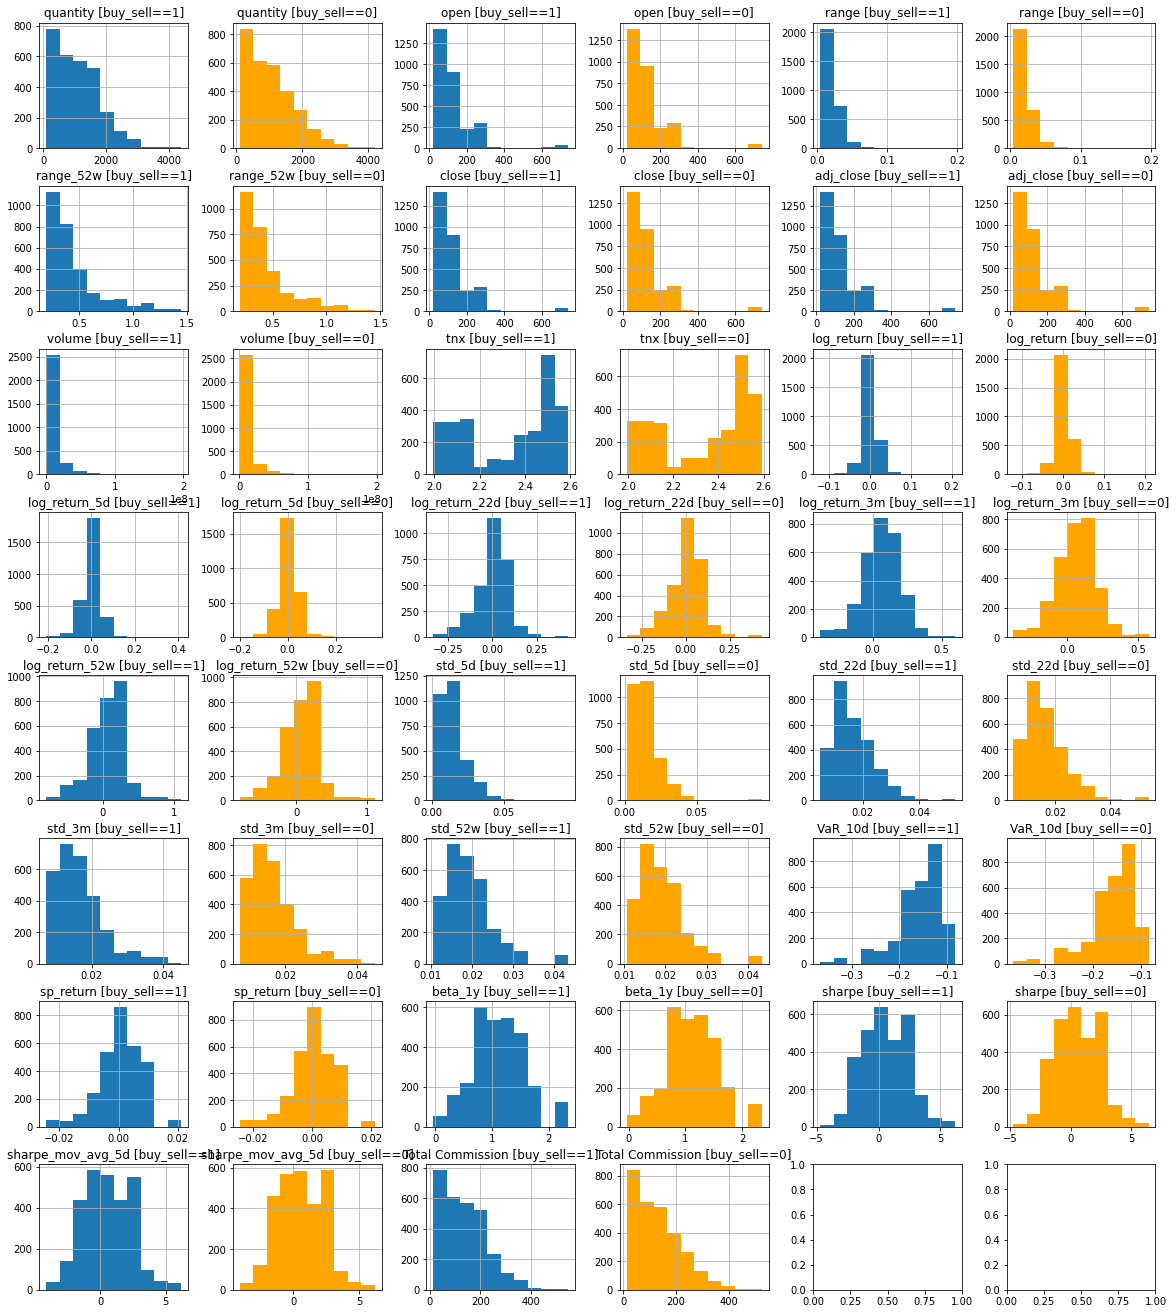

In [ ]:
continuous_variables = ['quantity','open', 'range', 'range_52w', 'close',	'adj_close',
                        'volume',	'tnx', 'log_return', 'log_return_5d',	'log_return_22d',	'log_return_3m',
                        'log_return_52w',	'std_5d',	'std_22d','std_3m','std_52w',
                        'VaR_10d','sp_return', 'beta_1y',	'sharpe',	'sharpe_mov_avg_5d','Total Commission']	

fig, ax = plt.subplots(8,6, figsize=(20, 16))
fig.subplots_adjust(bottom=0.4, top=1.5)
ax = ax.ravel()

for i, col in enumerate(continuous_variables):
    
    # Plot the feature when y is 1
    df_stock_encoded[df_stock_encoded['x0_buy'] == 1].hist(col, ax=ax[2*i])
    ax[2*i].set_title('{} [buy_sell==1]'.format(col))
    
    # Write code below to plot the feature when y is 0
    # -------------------------------------------------------------------------
    df_stock_encoded[df_stock_encoded['x0_buy'] == 0].hist(col, ax=ax[2*i+1], color = 'orange')
    ax[2*i+1].set_title('{} [buy_sell==0]'.format(col))
    
    # -------------------------------------------------------------------------


In [ ]:
df_stock_encoded = df_stock_encoded.drop(['clientName','company_name','headquarters_location', 'date_first_added','cik','founded','headquarters_location_city',\
                       'headquarters_location_country'],axis=1)
df_stock_encoded = df_stock_encoded.groupby(['ticker']).mean()
df_stock_encoded = pd.concat([df_stock_encoded,df_stock_encoded_sum],axis=1)

In [ ]:
df_stock_org = df_stock_encoded.copy()

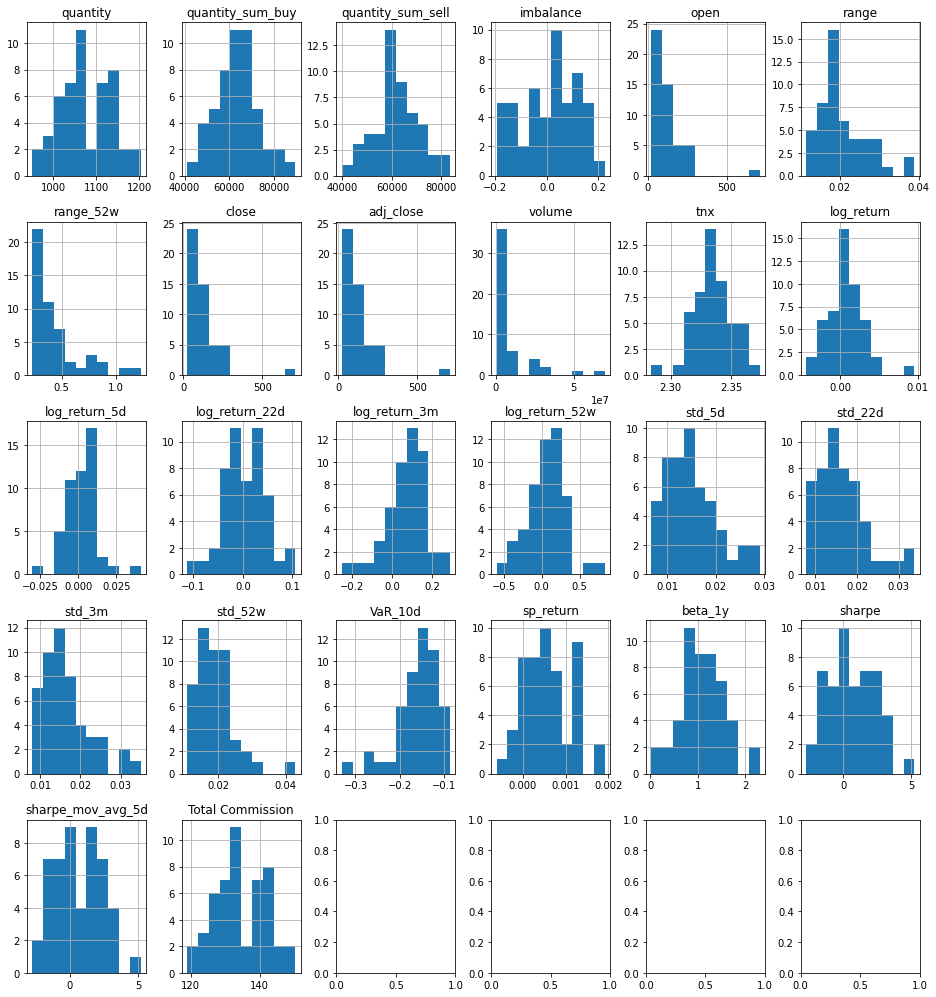

In [ ]:
continuous_variables = ['quantity','quantity_sum_buy','quantity_sum_sell','imbalance','open', 'range', 'range_52w', 'close',	'adj_close',
                        'volume',	'tnx', 'log_return', 'log_return_5d',	'log_return_22d',	'log_return_3m',
                        'log_return_52w',	'std_5d',	'std_22d','std_3m','std_52w',
                        'VaR_10d','sp_return', 'beta_1y',	'sharpe',	'sharpe_mov_avg_5d','Total Commission']	

fig, ax = plt.subplots(5,6, figsize=(16, 12))
fig.subplots_adjust(bottom=0.4, top=1.5)
ax = ax.ravel()

for i, col in enumerate(continuous_variables):
    
    # Plot the feature when y is 1
    df_stock_encoded.hist(col, ax=ax[i])
    ax[i].set_title('{}'.format(col))
    # -------------------------------------------------------------------------


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
   
df_stock_encoded[continuous_variables] = scaler.fit_transform(df_stock_encoded[continuous_variables])

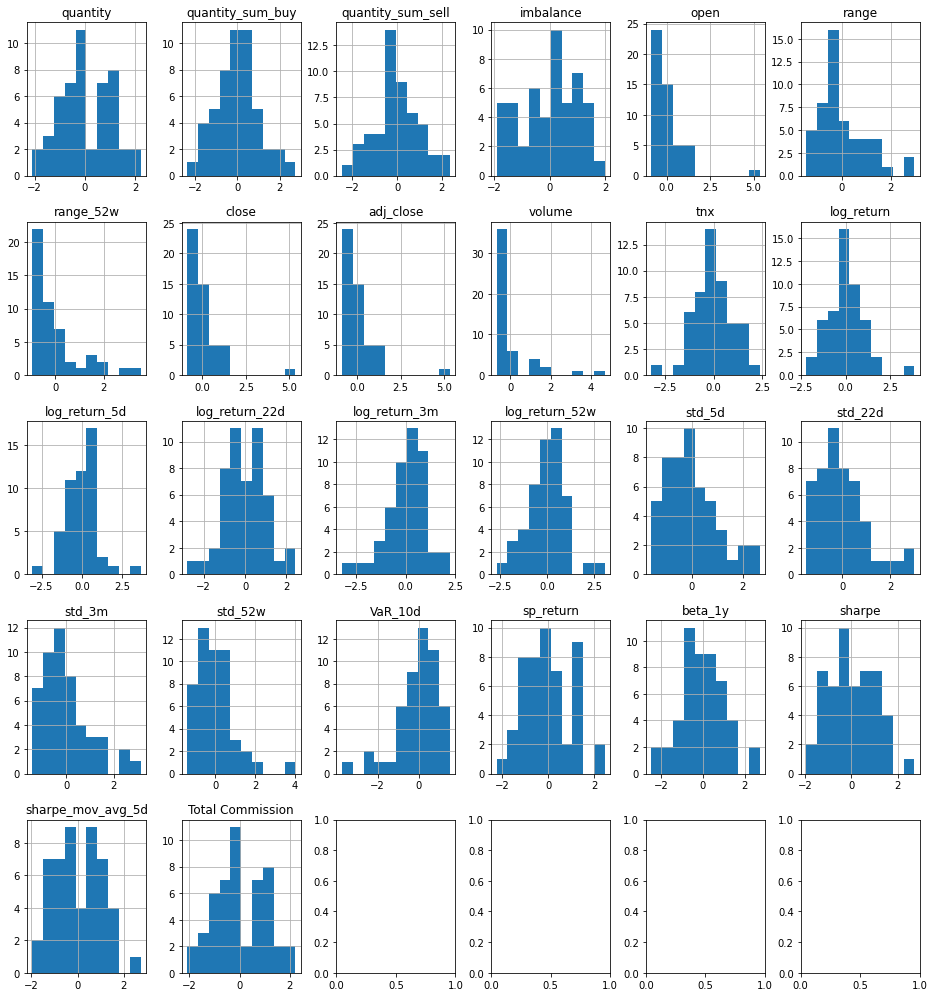

In [ ]:
fig, ax = plt.subplots(5,6, figsize=(16, 12))
fig.subplots_adjust(bottom=0.4, top=1.5)
ax = ax.ravel()

for i, col in enumerate(continuous_variables):
    
    # Plot the feature when y is 1
    df_stock_encoded.hist(col, ax=ax[i])
    ax[i].set_title('{}'.format(col))
    # -------------------------------------------------------------------------


In [ ]:
#'range', 'range_52w', 'volume',	'log_return_3m', 'std_3m', 'beta_1y',	'sharpe_mov_avg_5d'
df_stock_encoded_all = df_stock_encoded.copy()
df_stock_encoded_all

,quantity,open,close,adj_close,volume,tnx,log_return,log_return_5d,log_return_22d,log_return_3m,log_return_52w,std_5d,std_22d,std_3m,std_52w,VaR_10d,sp_return,beta_1y,sharpe,sharpe_mov_avg_5d,Fee/Share,Total Commission,x0_buy,x0_sell,x1_Communication Services,x1_Consumer Discretionary,x1_Consumer Staples,x1_Energy,x1_Financials,x1_Information Technology,x1_Materials,x2_Apparel Retail,"x2_Apparel, Accessories & Luxury Goods",x2_Application Software,x2_Automobile Manufacturers,x2_Brewers,x2_Casinos & Gaming,x2_Communications Equipment,x2_Computer & Electronics Retail,x2_Data Processing & Outsources Services,...,x2_Household Appliances,x2_Hypermarkets & Super Centers,x2_IT Services,x2_Integrated Telecommunication Services,x2_Interactive Home Entertainment,x2_Interactive Media & Services,x2_Internet & Direct Marketing Retail,x2_Internet Software & Services,x2_Movies & Entertainment,x2_Oil & Gas Exploration & Production,x2_Packaged Foods & Meats,x2_Personal Products,x2_Restaurants,x2_Semiconductor Equipment,x2_Semiconductors,x2_Soft Drinks,x2_Systems Software,"x2_Technology Hardware, Storage & Peripherals",x3_California,x3_Colorado,x3_Florida,x3_Georgia,x3_Illinois,x3_Massachusetts,x3_Michigan,x3_Minnesota,x3_Nevada,x3_New York,x3_North Carolina,x3_Ohio,x3_Oregon,x3_Tennessee,x3_Texas,x3_Washington,range,range_52w,quantity_sum_buy,quantity_sum_sell,imbalance,quantity_sum
ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-2.086182,0.683403,0.683824,0.684528,1.477664,-0.677106,-0.372932,0.039148,0.226173,0.767419,0.081555,-0.306373,-0.170486,-0.200400,0.024715,0.206999,-1.614598,0.875475,-0.074384,-0.076693,0.125,-2.086182,0.522936,0.477064,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.385835,0.136197,-1.004013,-1.375912,0.280877,103700
1,1.838723,1.444350,1.451396,1.455482,-0.517699,-0.033039,1.657254,0.880157,0.672325,0.386289,0.400853,0.360900,-0.142244,-0.453820,0.362957,-0.339222,1.471877,1.305682,0.200597,0.186318,0.125,1.838723,0.546763,0.453237,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.201564,-0.622178,2.733660,1.389685,0.740066,164100
2,0.636063,-0.104517,-0.103116,-0.103302,-0.499172,0.647603,-0.022961,0.362511,-0.228278,0.222192,0.353032,0.790175,0.382645,0.079624,-0.236382,0.239818,-0.285010,0.198186,0.384416,0.395057,0.125,0.636063,0.517241,0.482759,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174575,-0.288624,0.796387,-0.487367,0.863294,128800
3,-1.269095,-0.826989,-0.828010,-0.824901,4.683472,-0.484278,1.140109,0.756415,1.962406,1.755770,3.051137,2.660139,2.983080,3.119783,4.021441,-3.724566,0.481151,2.718903,1.406290,1.409306,0.125,-1.269095,0.518182,0.481818,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.698365,1.514965,-0.814497,-0.887212,0.038894,109900
4,-1.119743,1.552173,1.551892,1.532832,-0.492348,0.077742,-0.839079,-0.492312,-0.517245,0.120492,0.534150,0.116917,0.275061,0.204513,0.549173,0.057690,-0.236554,0.233336,0.449675,0.464520,0.125,-1.119743,0.515625,0.484375,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.398785,-0.051023,0.533171,-0.187483,0.486585,129000
5,-1.096553,-0.826137,-0.826158,-0.824111,3.308433,-0.458259,-0.177197,-0.476956,-0.428074,-0.487416,-0.370872,-0.200117

In [ ]:
use_variables = ['quantity','imbalance','Total Commission']
df_stock_encoded = df_stock_encoded_all[use_variables]

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_stock_encoded)
df_stock_encoded['labels'] = kmeans.labels_
#df_stock_encoded.groupby(['labels','ticker']).mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


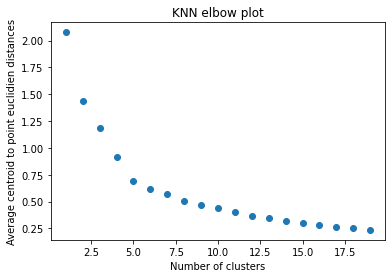

In [ ]:
from scipy.spatial.distance import cdist

number_of_clusters = list(range(1,20))
average_distance = []
mdk_k_means = KMeans(n_init = 50,  random_state = 1, n_jobs=-1)

for k in number_of_clusters: # Run algorithm for 1 to 8 clusters
    # Redefine the number of clusters in the model, and fir the model
    #-----------------
    mdk_k_means = KMeans(n_init = 50, n_clusters = k, random_state = 1, n_jobs=-1)
    mdk_k_means.fit(df_stock_encoded)
    # -------------------
    
    # Get distances for each point that is fit to the model
    Centroids = mdk_k_means.cluster_centers_
    distances_from_clusters = mdk_k_means.transform(df_stock_encoded)
    
    # Get y values (avg distance) for the plot
    # -------------------
    average_distance.append(sum(np.min(distances_from_clusters, axis=1)) / df_stock_encoded.shape[0])
    
    # -------------------

plt.figure(figsize=(6,4))
plt.scatter(number_of_clusters,average_distance)
plt.ylabel('Average centroid to point euclidien distances')
plt.xlabel('Number of clusters')
plt.title('KNN elbow plot')
plt.show()

In [ ]:
mdk_k_means = KMeans(n_init = 50, n_clusters = 6, random_state = 1, n_jobs=-1)
mdk_k_means.fit(df_stock_encoded)
mdk_k_means.labels_

array([0, 4, 3, 0, 0, 0, 2, 2, 3, 1, 5, 5, 2, 0, 5, 2, 3, 1, 1, 2, 5, 2,
       3, 5, 3, 5, 3, 5, 0, 3, 4, 2, 5, 0, 2, 3, 0, 5, 3, 4, 2, 3, 5, 1,
       5, 1, 0, 0, 5, 1], dtype=int32)

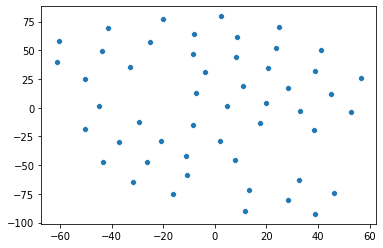

In [ ]:
from sklearn.manifold import TSNE
#metric='cosine'
TSNER = TSNE(metric='cosine')
embedded = TSNER.fit_transform(df_stock_encoded)
sns.scatterplot(x=embedded[:,0], y=embedded[:,1])

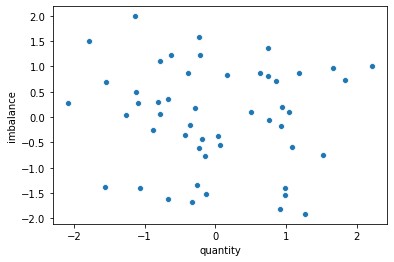

In [ ]:
sns.scatterplot(x=df_stock_encoded.iloc[:,0], y=df_stock_encoded.iloc[:,1])

Text(0.5, 1.0, 'stock clustering - t-SNE')

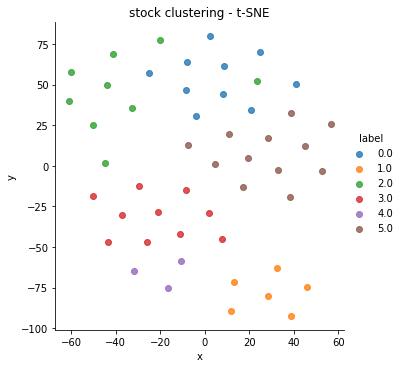

In [ ]:
plotdata = pd.DataFrame(np.concatenate([embedded,mdk_k_means.labels_.reshape(-1,1)],axis=1),columns=['x','y','label'])
sns.lmplot(data=plotdata, x='x', y='y',hue='label',fit_reg=False,legend=True, legend_out=True)
ax = plt.gca()
ax.set_title("stock clustering - t-SNE")

In [ ]:
agg_mdl = AgglomerativeClustering(n_clusters=5).fit(df_stock_encoded)

Text(0.5, 1.0, 'stock clustering - total commission vs imbalance')

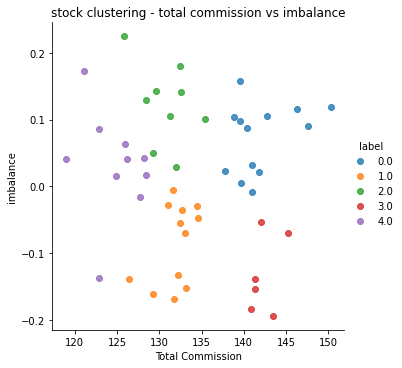

In [ ]:
plotdata = pd.DataFrame(np.concatenate([np.array(df_stock_org[['Total Commission','imbalance']]),agg_mdl.labels_.reshape(-1,1)],axis=1),columns=['Total Commission','imbalance','label'])
sns.lmplot(data=plotdata, x='Total Commission', y='imbalance',hue='label',fit_reg=False,legend=True, legend_out=True)
ax = plt.gca()
ax.set_title("stock clustering - total commission vs imbalance")

Text(0.5, 1.0, 'stock clustering - t-SNE')

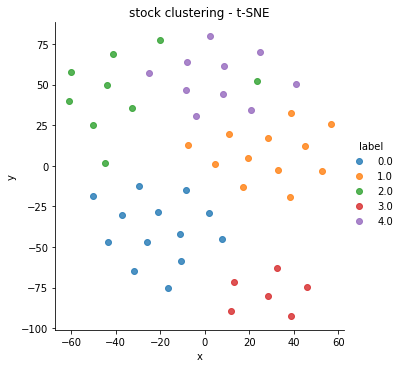

In [ ]:
plotdata = pd.DataFrame(np.concatenate([embedded,agg_mdl.labels_.reshape(-1,1)],axis=1),columns=['x','y','label'])
sns.lmplot(data=plotdata, x='x', y='y',hue='label',fit_reg=False,legend=True, legend_out=True)
ax = plt.gca()
ax.set_title("stock clustering - t-SNE")

In [ ]:
df_stock_org['agg_label'] = agg_mdl.labels_
df_stock_org['tickers'] = tickers
new = use_variables + ['agg_label','tickers']
df_stock_org[new].groupby(['agg_label','tickers']).mean()

quantity  imbalance  Total Commission
agg_label tickers                                          
0         ADBE     1180.575540   0.090798        147.571942
          ADI      1110.344828   0.104037        138.793103
          CCL      1141.964286   0.105551        142.745536
          EA       1134.166667   0.021308        141.770833
          HD       1127.419355  -0.008584        140.927419
          JNPR     1116.800000   0.157593        139.600000
          JWN      1102.479339   0.022489        137.809917
          MSFT     1123.437500   0.087622        140.429688
          MSI      1170.175439   0.115442        146.271930
          PEP      1117.307692   0.005164        139.663462
          QRVO     1116.806723   0.098570        139.600840
          SWKS     1202.608696   0.119306        150.326087
          TAP      1128.070175   0.032659        141.008772
1         COST     1061.818182  -0.035959        132.727273
          CRM      1048.120301  -0.027260        131.015038
          DG       1011.206897  -0.138960        126.400862
          GLW      1064.285714  -0.070470        133.035714
          INTC     1053.488372  -0.168506        131.686047
          JPM      1052.631579  -0.005000        131.578947
          LRCX     1058.119658  -0.132472        132.264957
          NEM      1034.482759  -0.161667        129.310345
          QCOM     1075.630252  -0.029687        134.453782
          TJX      1077.064220  -0.047700        134.633028
          TXN      1065.517241  -0.152104        133.189655
          WHR      1059.836066  -0.054911        132.479508
2         BBY      1006.862745   0.224927        125.857843
          C        1034.285714   0.049724        129.285714
          CSCO     1083.035714   0.101401        135.379464
          DIS      1060.550459   0.141869        132.568807
          GIS      1056.302521   0.029435        132.037815
          GM       1060.000000   0.180103        132.500000
          NBL      1036.697248   0.143363        129.587156
          NVDA     1027.131783   0.129057        128.391473
          T        1050.359712   0.105479        131.294964
3         CMG      1130.693069  -0.138354        141.336634
          EXPE     1126.923077  -0.184300        140.865385
          FLT      1147.368421  -0.194190        143.421053
          TRIP     1130.468750  -0.154112        141.308594
          V        1136.220472  -0.053361        142.027559
          WYNN     1162.280702  -0.070189        145.285088
4         AAPL      951.376147   0.041466        118.922018
          AMD       999.090909   0.015469        124.886364
          AVGO     1007.812500   0.063566        125.976562
          BAC      1009.166667   0.040462        126.145833
          CTXS      982.474227  -0.137461        122.809278
          MA       1025.954198   0.043155        128.244275
          NKE      1027.272727   0.016895        128.409091
          PG        983.035714   0.086285        122.879464
          WBA      1021.311475  -0.016051        127.663934
          WDC       969.026549   0.172603        121.128319

In [ ]:
df_stock_org['kmean_label'] = mdk_k_means.labels_
df_stock_org['tickers'] = tickers
new = use_variables + ['kmean_label','tickers']
df_stock_org[new].groupby(['kmean_label','tickers']).mean()

quantity_sum  imbalance  log_return_3m    std_3m
kmean_label tickers                                                  
0           ADI            128800   0.104037       0.089188  0.016951
            AVGO           129000   0.063566       0.079105  0.017690
            CCL            127900   0.105551      -0.050791  0.016965
            EA             136100   0.021308       0.011025  0.026742
            FLT            130800  -0.194190       0.200777  0.012847
            GIS            125700   0.029435       0.150101  0.011055
            INTC           135900  -0.168506      -0.007760  0.017651
            JWN            133400   0.022489      -0.196191  0.017791
            MA             134400   0.043155       0.155769  0.010847
            MSI            133400   0.115442       0.150299  0.014171
            NVDA           132500   0.129057       0.073902  0.025247
            QCOM           128000  -0.029687       0.290298  0.030509
            QRVO           132900   0.098570       0.053761  0.019890
            TAP            128600   0.032659      -0.045355  0.016786
            WHR            129300  -0.054911       0.039285  0.018542
            WYNN           132500  -0.070189       0.104859  0.023579
1           AAPL           103700   0.041466       0.143242  0.015294
            AMD            109900   0.015469       0.241230  0.034939
            BBY            102700   0.224927       0.147559  0.019090
            C              108600   0.049724       0.080458  0.015194
            CTXS            95300  -0.137461      -0.050633  0.009405
            PG             110100   0.086285       0.099299  0.008802
            WDC            109500   0.172603      -0.012486  0.030212
2           ADBE           164100   0.090798       0.105456  0.013794
3           BAC            121100   0.040462       0.018836  0.014307
            CMG            114200  -0.138354       0.216621  0.016081
            COST           116800  -0.035959       0.138193  0.010142
            CSCO           121300   0.101401       0.135785  0.011672
            DG             117300  -0.138960       0.086569  0.013396
            DIS            115600   0.141869       0.166152  0.015934
            EXPE           117200  -0.184300       0.027084  0.011497
            GLW            119200  -0.070470      -0.024858  0.015106
            GM             116600   0.180103       0.008787  0.013739
            JPM            120000  -0.005000       0.078708  0.012291
            LRCX           123800  -0.132472       0.139379  0.020758
            NBL            113000   0.143363       0.034395  0.024487
            NEM            120000  -0.161667       0.025983  0.015251
            NKE            124300   0.016895       0.035097  0.013259
            PEP            116200   0.005164       0.127073  0.008041
            TJX            117400  -0.047700       0.073994  0.010496
            TXN            123600  -0.152104       0.077600  0.015177
            WBA            124600  -0.016051      -0.252657  0.022046
4           CRM            139400  -0.027260       0.018930  0.016342
            HD             139800  -0.008584       0.092188  0.010319
            JNPR           139600   0.157593      -0.002475  0.013876
            MSFT           143800   0.087622       0.161865  0.012063
            SWKS           138300   0.119306       0.047536  0.022042
            T              146000   0.105479       0.060376  0.011153
            TRIP           144700  -0.154112      -0.117957  0.021367
            V              144300  -0.053361       0.132353  0.009146

In [ ]:
df_stock_org[new].to_csv('stock_clustering.csv')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
pd.DataFrame(cosine_similarity(df_stock_encoded),columns = tickers, index = tickers)

,AAPL,ADBE,ADI,AMD,AVGO,BAC,BBY,C,CCL,CMG,COST,CRM,CSCO,CTXS,DG,DIS,EA,EXPE,FLT,GIS,GLW,GM,HD,INTC,JNPR,JPM,JWN,LRCX,MA,MSFT,MSI,NBL,NEM,NKE,NVDA,PEP,PG,QCOM,QRVO,SWKS,T,TAP,TJX,TRIP,TXN,V,WBA,WDC,WHR,WYNN
AAPL,1.000000,-0.581555,-0.218343,0.413078,0.928348,0.364440,0.523404,0.654099,-0.733333,-0.425111,0.337272,0.560970,-0.148372,0.598103,0.532595,0.378520,-0.965998,-0.371982,-0.463835,0.231523,-0.182728,0.025645,-0.452742,-0.068582,-0.415573,0.557430,-0.519546,0.173488,0.867219,-0.307406,-0.514746,0.187031,0.025011,0.707898,0.697332,-0.368451,0.955494,-0.331785,-0.597491,-0.832370,0.067449,-0.945202,-0.336264,-0.664590,0.079493,-0.507299,0.648153,0.586607,0.317077,-0.610733
ADBE,-0.581555,1.000000,0.897165,-0.902462,-0.241094,-0.836178,-0.231534,-0.742019,0.620920,0.458873,0.188200,0.006731,0.216768,-0.852144,-0.463937,0.454763,0.748045,0.320740,0.397665,-0.724979,-0.692074,-0.235691,0.869688,-0.676367,0.094561,0.150105,-0.246540,-0.091964,-0.107684,0.951932,0.992525,-0.456426,-0.799205,-0.928317,0.093229,0.878474,-0.359752,-0.541062,0.599123,0.816264,-0.478250,0.657017,-0.496898,-0.116205,-0.053011,0.755819,-0.995186,-0.615289,0.094748,0.769735
ADI,-0.218343,0.897165,1.000000,-0.764282,0.158559,-0.681201,0.171018,-0.418852,0.537020,0.133988,0.180970,0.094744,0.415161,-0.837690,-0.490938,0.799910,0.456110,-0.014806,0.043839,-0.584259,-0.875099,-0.034868,0.688787,-0.929606,0.130456,0.290385,-0.400987,-0.260516,0.248374,0.978104,0.941542,-0.236130,-0.980812,-0.682667,0.516049,0.748239,0.059701,-0.846942,0.598384,0.657014,-0.327085,0.401954,-0.827804,-0.539331,-0.261122,0.493351,-0.849614,-0.272865,0.046418,0.472395
AMD,0.413078,-0.902462,-0.764282,1.000000,0.107828,0.990606,0.489264,0.881927,-0.237645,-0.741347,-0.577728,-0.395250,0.206555,0.544347,0.037534,-0.351407,-0.536386,-0.633479,-0.675564,0.950899,0.747720,0.624333,-0.993577,0.496854,0.339490,-0.485660,0.548604,-0.339333,-0.079912,-0.881345,-0.867536,0.786280,0.688241,0.935609,-0.059472,-0.998343,0.268205,0.485040,-0.196580,-0.523262,0.809794,-0.375915,0.389485,0.057000,-0.367348,-0.935819,0.906096,0.817309,-0.509332,-0.914560
AVGO,0.928348,-0.241094,0.158559,0.107828,1.000000,0.086653,0.567234,0.478948,-0.556614,-0.348653,0.440084,0.629971,-0.023046,0.298522,0.377659,0.679568,-0.805821,-0.350741,-0.422686,-0.014558,-0.526670,-0.020871,-0.174492,-0.413867,-0.401262,0.697833,-0.700059,0.108794,0.978393,0.066396,-0.159482,0.067231,-0.346066,0.441593,0.893777,-0.067585,0.985227,-0.655149,-0.398772,-0.601327,-0.087628,-0.811947,-0.647842,-0.867949,0.013754,-0.300032,0.325337,0.462901,0.369847,-0.414450
BAC,0.364440,-0.836178,-0.681201,0.990606,0.086653,1.000000,0.569110,0.902383,-0.114860,-0.811975,-0.669234,-0.489286,0.337714,0.425690,-0.095660,-0.282085,-0.464375,-0.719098,-0.749701,0.983061,0.717879,0.725224,-0.995126,0.403078,0.457630,-0.556075,0.604967,-0.464775,-0.111366,-0.816355,-0.791380,0.862775,0.610615,0.908405,-0.020447,-0.995336,0.253314,0.426175,-0.064786,-0.418987,0.881447,-0.288142,0.317991,0.010330,-0.490557,-0.962190,0.844830,0.860919,-0.614235,-0.933377
BBY,0.523404,-0.231534,0.171018,0.489264,0.567234,0.569110,1.000000,0.821141,0.176897,-0.933824,-0.471145,-0.279474,0.763597,-0.172848,-0.437180,0.620218,-0.383334,-0.962206,-0.967470,0.605219,-0.133033,0.804392,-0.584809,-0.512291,0.521633,-0.156886,0.112158,-0.742677,0.412012,-0.035702,-0.112732,0.809137,-0.295933,0.575592,0.734481,-0.496431,0.666053,-0.487765,0.341861,-0.081575,0.698056,-0.229850,-0.593702,-0.759150,-0.803794,-0.765127,0.312066,0.900878,-0.552507,-0.787582
C,0.654099,-0.742019,-0.418852,0.881927,0.478948,0.902383,0.821141,1.000000,-0.196402,-0.924292,-0.487746,-0.255397,0.428870,0.355951,-0.072195,0.130007,-0.660137,-0.862999,-0.906874,0.870549,0.353183,0.726242,-0.926932,0.059396,0.354106,-0.256291,0.281017,-0.494089,0.288710,-0.594603,-0.657411,0.853643,0.284318,0.934533,0.410793,-0.876013,0.622206,0.015565,-0.075560,-0.496646,0.797592,-0.494135,-0.088198,-0.417108,-0.554346,-0.9810

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
df_client = df.copy()
df_client[['ticker','quantity','']]
pd.DataFrame(cosine_similarity(df_client),columns = tickers, index = tickers)